# HPH第四版实验

### 思路

*id统计相关*
1. item_id, shop_id的交易量, 交易率
2. item_id, shop_id7天是否新出现, 3天是否新出现, 昨天是否新出现
3. 提交并且验证线上分数

In [1]:
import sys
sys.path.append("..")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

train_df = pd.read_table('../../round1_ijcai_18_train_20180301.txt',sep=' ')
test_df = pd.read_table('../../round1_ijcai_18_test_a_20180301.txt',sep=' ')

# 线下线上数据统一进行特征处理
test_df['is_trade'] = -1
total_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# 1 数据集统一处理

In [2]:
# 时间处理: 分离天, 星期几, 上中下午/晚上, 小时数
# date最终不使用，直接用day(第 0 - 7 天)

from sklearn import preprocessing
from datetime import datetime
le = preprocessing.LabelEncoder()

def extract_date(x):
    d = datetime.fromtimestamp(x)
    return d.strftime('%Y-%m-%d')
def extract_weekday(x):
    d = datetime.fromtimestamp(x)
    return d.weekday()
def extract_hour(x):
    d = datetime.fromtimestamp(x)
    return d.hour

total_df['date'] = total_df['context_timestamp'].apply(lambda x: extract_date(x))
total_df['day'] = le.fit_transform(total_df['date'])
total_df['weekday'] = total_df['context_timestamp'].apply(lambda x: extract_weekday(x))
total_df['hour'] = total_df['context_timestamp'].apply(lambda x: extract_hour(x))

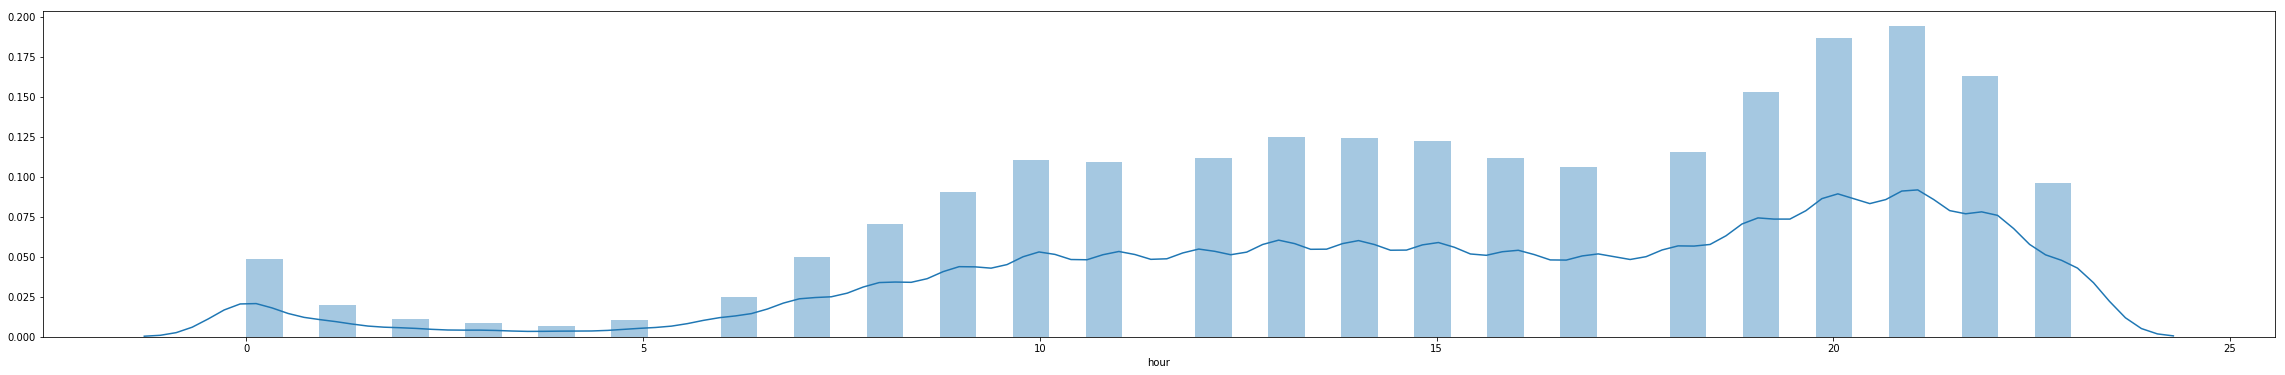

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 1, figsize=(40, 6))
sns.distplot(total_df['hour'], ax=ax)
#total_df['hour'].plot(kind='hist')

In [4]:
%run ../util/time_utils.py
# 穿越特征, 过去1 ~ 7天是否出现的标记

for i in range(1, 8):

    total_df = getColDupByDate(total_df, 'date', 'item_id', i)
    total_df = getColDupByDate(total_df, 'date', 'item_brand_id', i)
    total_df = getColDupByDate(total_df, 'date', 'shop_id', i)
    total_df = getColDupByDate(total_df, 'date', 'user_id', i)

In [ ]:
# 计算前一天的交易率set到下一天，第0天用回自己
%run ../util/time_utils.py

setTradeRateByDate(total_df, \
                   ['item_city_id', 'item_id', 'item_brand_id', \
                    'shop_id', 'user_gender_id', 'hour'])

In [14]:
total_df.columns.values

array(['instance_id', 'item_id', 'item_category_list',
       'item_property_list', 'item_brand_id', 'item_city_id',
       'item_price_level', 'item_sales_level', 'item_collected_level',
       'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level',
       'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'date', 'day', 'weekday',
       'hour', 'item_id_dup_g_1', 'item_brand_id_dup_g_1',
       'shop_id_dup_g_1', 'user_id_dup_g_1', 'item_id_dup_g_2',
       'item_brand_id_dup_g_2', 'shop_id_dup_g_2', 'user_id_dup_g_2',
       'item_id_dup_g_3', 'item_brand_id_dup_g_3', 'shop_id_dup_g_3',
       'user_id_dup_g_3', 'item_id_dup_g_4', 'item_brand_id_dup_g_4',
       'shop_id_dup_g_4', 'user_id_dup_g_4', 'item_id_du

In [15]:
# 分桶
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()

# total_df['item_city_id_pv_cut'] = pd.cut(total_df['item_city_id_pv'].values, bins=10, retbins=False)
# total_df['item_id_pv_cut'] = pd.cut(total_df['item_id_pv'].values, bins=10, retbins=False)
# total_df['shop_id_pv_cut'] = pd.cut(total_df['shop_id_pv'].values, bins=10, retbins=False)
# total_df['item_brand_id_pv_cut'] = pd.cut(total_df['item_brand_id_pv'].values, bins=10, retbins=False)
# total_df['user_occupation_id_pv_cut'] = pd.cut(total_df['user_occupation_id_pv'].values, bins=10, retbins=False)

# total_df['item_city_id_pv_cut'] = le.fit_transform(total_df['item_city_id_pv_cut'].copy())
# total_df['item_id_pv_cut'] = le.fit_transform(total_df['item_id_pv_cut'].copy())
# total_df['shop_id_pv_cut'] = le.fit_transform(total_df['shop_id_pv_cut'].copy())
# total_df['item_brand_id_pv_cut'] = le.fit_transform(total_df['item_brand_id_pv_cut'].copy())
# total_df['user_occupation_id_pv_cut'] = le.fit_transform(total_df['user_occupation_id_pv_cut'].copy())

In [16]:
# standardization and scaling

# from sklearn import preprocessing

# def scale(df, idCol):
#     min_max_scaler = preprocessing.RobustScaler()
#     a = min_max_scaler.fit_transform(df[idCol].values.reshape(-1, 1))
#     return pd.Series(a.reshape(1, -1)[0])

# # 令数据再少一些?
# total_df['shop_score_service_scaled'] = scale(total_df, 'shop_score_service')
# total_df['shop_score_delivery_scaled'] = scale(total_df, 'shop_score_delivery')
# total_df['shop_score_description_scaled'] = scale(total_df, 'shop_score_description')
# total_df['shop_review_positive_rate_scaled'] = scale(total_df, 'shop_review_positive_rate')

# for col in total_df:
#     if not col.startswith('exp_d'):
#         continue
#     total_df[col + '_scaled'] = scale(total_df, col)

# # 变得可重入
# for col in total_df:
#     if col.endswith('_scaled_scaled'):
#         del total_df[col]

# 2 生成矩阵数据

In [ ]:
total_df.columns.values

In [64]:
train_df = total_df[total_df['is_trade']>=0]
test_df = total_df[total_df['is_trade']<0]

non_feat_columns = ['context_timestamp', 'instance_id', 'is_trade', 'context_id',
                   'item_property_list', 'item_category_list', 'date', 'predict_category_property'
                   ]

D = train_df[['date']]
feat_cols = train_df.drop(non_feat_columns, axis=1).columns
X = train_df.drop(non_feat_columns, axis=1)
y = train_df[['is_trade']].values.ravel()

X_online = test_df.drop(non_feat_columns, axis=1).values
print(D.shape, X.shape, y.shape, X_online.shape)

(478138, 1) (478138, 70) (478138,) (18371, 70)


In [66]:
# 训练模型
# from sklearn.model_selection import GridSearchCV as GSCV   #Perforing grid search
# from sklearn.metrics import make_scorer
from sklearn.metrics import log_loss
import xgboost
from xgboost import plot_importance

import lightgbm as lgb

%run ../util/time_series_split.py


m = None

# 出离线结果, 留空最后一天数据
train_i = D[(D['date'] >= '2018-09-18') & (D['date'] <= '2018-09-23')].index.values
test_i = D[D['date'] == '2018-09-24'].index.values

print(train_indices.shape, test_indices.shape)
dtsv = DateTimeSplit(dateSeries=D, fmt="%Y-%m-%d")
for train_i, test_i in dtsv.split(X, y):
    X_train, y_train = X.iloc[train_i], y[train_i]
    X_test, y_test = X.iloc[test_i], y[test_i]

    # clf = lgb.LGBMClassifier(n_jobs=20)
    clf = xgboost.XGBClassifier(n_jobs=5)
    m = clf.fit(X_train, y_train)
    print('train logloss: %s, test logloss: %s' % \
          (log_loss(y_train, m.predict_proba(X_train)), \
           log_loss(y_test, m.predict_proba(X_test))))
# baseline train logloss: 0.0900087417141, test logloss: 0.082721774823
# without duplicatie train logloss: 0.0901497906901, test logloss: 0.0827584824615
# 没有平滑交易率: train logloss: 0.0766156769486, test logloss: 0.0824794973167
# + smooth = 100, mean = 0.1 train logloss: 0.0773046615726, test logloss: 0.0823854984755
# + smooth = 200, mean = 0.05 train logloss: 0.0770508661308, test logloss: 0.0823597300654
# + 过去7天作为交易率 train logloss: 0.0769139145409, test logloss: 0.082069491692
# + 训练数据丢弃第一天 train logloss: 0.0885656144401, test logloss: 0.081962601964


(420717,) (57421,)
train logloss: 0.0768156751597, test logloss: 0.0820508909785


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x114514b00>>
Traceback (most recent call last):
  File "/Users/prehawkmac/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


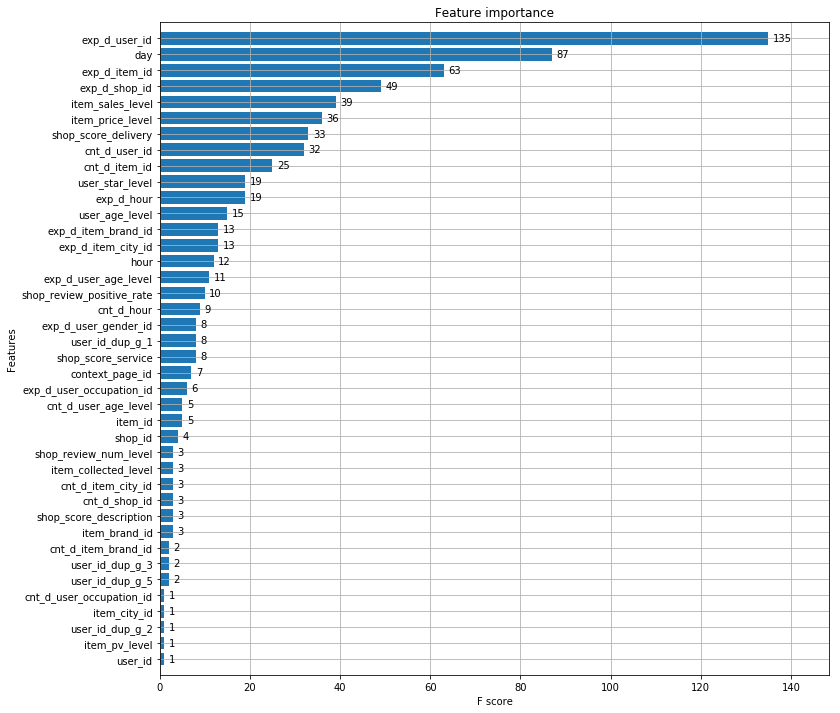

In [67]:
fig, ax = plt.subplots(figsize=(12,12))  
a = xgboost.plot_importance(m, height=0.8, ax=ax) 
plt.show()

In [ ]:
ft_weights = pd.DataFrame(m.feature_importances_, columns=['weights'], index=list(X_train.columns))
print(ft_weights)

In [160]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((342449, 66), (342449,), (57421, 66), (57421,))

In [63]:
# 输出比赛格式
online_i = D[(D['date'] >= '2018-09-18') & (D['date'] <= '2018-09-24')].index.values
m = clf.fit(X[online_i], y[online_i])
result = pd.DataFrame()
result['instance_id'] = test_df['instance_id']
result['predicted_score'] = pd.DataFrame(m.predict_proba(X_online))[1].values
result.to_csv('off8205.csv', sep = ' ', header=True, index = False)

